<a href="https://colab.research.google.com/github/Tiff923/Music-Generation/blob/main/LSTM_with_more_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import glob

from google.colab import files
from pathlib import Path

import glob
import os
import music21
import numpy as np
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, duration, stream

In [ ]:
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from music21 import *
import numpy
import glob
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# New Section

In [ ]:
def note_to_int(note): # converts the note's letter to pitch value which is integer form.
 
    note_base_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    if ('#-' in note):
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[3]
        value = base_value + 12*(int(octave)-(-1))
        
    elif ('#' in note): 
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[2]
        value = base_value + 12*(int(octave)-(-1))
        
    elif ('-' in note): 
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[2]
        value = base_value + 12*(int(octave)-(-1))
        
    else:
        first_letter = note[0]
        base_val = note_base_name.index(first_letter)
        octave = note[1]
        value = base_val + 12*(int(octave)-(-1))
        
    return value

In [ ]:
# Lets determine our matrix's value 
# rest --> (min_value, lower_bound)
# continuation --> (lower_bound, upper_bound)
# first_touch --> (upper_bound, max_value)

min_value = 0.00
lower_first = 0.00

lower_second = 0.5
upper_first = 0.5

upper_second = 1.0
max_value = 1.0

def notes_to_matrix(notes, durations, offsets, min_value=min_value, lower_first=lower_first,
                    lower_second=lower_second,
                    upper_first=upper_first, upper_second=upper_second,
                    max_value=max_value):
    
    # I want to represent my notes in matrix form. X axis will represent time, Y axis will represent pitch values.
    # I should normalize my matrix between 0 and 1.
    # So that I will represent rest with (min_value, lower_first), continuation with [lower_second, upper_first]
    # and first touch with (upper_second, max_value)
    # First touch means that you press the note and it cause to 1 time duration playing. Continuation
    # represent the continuum of this note playing. 
    
    try:
        last_offset = int(offsets[-1]) 
    except IndexError:
        print ('Index Error')
        return (None, None, None)
    
    total_offset_axis = last_offset * 4 + (8 * 4) 
    our_matrix = np.random.uniform(min_value, lower_first, (128, int(total_offset_axis))) 
    # creates matrix and fills with (-1, -0.3), this values will represent the rest.
    
    for (note, duration, offset) in zip(notes, durations, offsets):
        how_many = int(float(duration)/0.25) # indicates time duration for single note.
       
        
        # Define difference between single and double note.
        # I have choose the value for first touch, the another value for continuation.
        # Lets make it randomize
        
        # I choose to use uniform distrubition. Maybe, you can use another distrubition like Gaussian.
        # I will try 
        first_touch = np.random.uniform(upper_second, max_value, 1)
        continuation = np.random.uniform(lower_second, upper_first, 1)
        
        if ('.' not in str(note)): # For a single note
            our_matrix[int(note), int(offset * 4)] = first_touch
            our_matrix[int(note), int((offset * 4) + 1) : int((offset * 4) + how_many)] = continuation

        else: # For chord
            chord_notes_str = [note for note in note.split('.')] 
            chord_notes_float = list(map(int, chord_notes_str)) # Take notes in chord one by one

            for chord_note_float in chord_notes_float:
                our_matrix[chord_note_float, int(offset * 4)] = first_touch
                our_matrix[chord_note_float, int((offset * 4) + 1) : int((offset * 4) + how_many)] = continuation
                
    return our_matrix

def check_float(duration): # This function fix the issue which comes from some note's duration. 
                           # For instance some note has duration like 14/3 or 7/3. 
    if ('/' in duration):
        numerator = float(duration.split('/')[0])
        denominator = float(duration.split('/')[1])
        duration = str(float(numerator/denominator))
    return duration

In [ ]:
def midi_to_matrix(filename, length):
  midi = converter.parse(filename)
  notes_to_parse = None
  print("Parsing %s" % filename)
  notes_to_parse = None


  try:
    s2 = instrument.partitionByInstrument(midi)
    notes_to_parse = s2.parts[0].recurse() 
  except:
    notes_to_parse = midi.flat.notes

  durations = []
  notes = []
  offsets = []
    
  for element in notes_to_parse:
    if isinstance(element, note.Note): #If it is a note
      notes.append(note_to_int(str(element.pitch))) # Append note's integer value to "notes" list.
      duration = str(element.duration)[27:-1] 
      durations.append(check_float(duration)) 
      offsets.append(element.offset)

    elif isinstance(element, chord.Chord): # If it is a chord
      notes.append('.'.join(str(n) for n in element.normalOrder))
      duration = str(element.duration)[27:-1]
      durations.append(check_float(duration))
      offsets.append(element.offset)

  our_matrix = notes_to_matrix(notes, durations, offsets)
    
  try:
    freq, time = our_matrix.shape
  except AttributeError:
    print ("'tuple' object has no attribute 'shape'")
    return None
            
  if (time >= length):
    return (our_matrix[:,:length]) # We have to set all individual note matrix to same shape for Generative DL.
  else:
    print ('%s have not enough duration' %(filename))

In [ ]:
def int_to_note(integer):
    # Convert pitch value to the note which is a letter form. 
    note_base_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave_detector = (integer // 12) 
    base_name_detector = (integer % 12) 
    note = note_base_name[base_name_detector] + str((int(octave_detector))-1)
    if ('-' in note):
      note = note_base_name[base_name_detector] + str(0)
      return note
    return note

# PAY ATTENTION. From matrix form to midi form, I have to indicate first touch, continuation and rest with unique numbers.
# I choose -1.0 for rest , 0 for continuation and 1 for first touch.

lower_bound = (lower_first + lower_second) / 2
upper_bound = (upper_first + upper_second) / 2

def converter_func(arr,first_touch = 1.0, continuation = 0.0, lower_bound = lower_bound, upper_bound = upper_bound):
    # I can write this function thanks to https://stackoverflow.com/questions/16343752/numpy-where-function-multiple-conditions
    # First touch represent start for note, continuation represent continuation for first touch, 0 represent end or rest
    np.place(arr, arr < lower_bound, -1.0)
    np.place(arr, (lower_bound <= arr) & (arr < upper_bound), 0.0)
    np.place(arr, arr >= upper_bound, 1.0)
    return arr

def how_many_repetitive_func(array, from_where=0, continuation=0.0):
    new_array = array[from_where:]
    count_repetitive = 1 
    for i in new_array:
        if (i != continuation):
            return (count_repetitive)
        else:
            count_repetitive += 1
    return (count_repetitive)

def matrix_to_midi(matrix, random=0):
    first_touch = 1.0
    continuation = 0.0
    y_axis, x_axis = matrix.shape
    output_notes = []
    offset = 0
        
    # Delete rows until the row which include 'first_touch'
    how_many_in_start_zeros = 0
    for x_axis_num in range(x_axis):
        one_time_interval = matrix[:,x_axis_num] # Values in a column.
        one_time_interval_norm = converter_func(one_time_interval)
        if (first_touch not in one_time_interval_norm):
            how_many_in_start_zeros += 1
        else:
            break
            
    how_many_in_end_zeros = 0
    for x_axis_num in range(x_axis-1,0,-1):
        one_time_interval = matrix[:,x_axis_num] # values in a column
        one_time_interval_norm = converter_func(one_time_interval)
        if (first_touch not in one_time_interval_norm):
            how_many_in_end_zeros += 1
        else:
            break
        
    print ('How many rows for non-start note at beginning:', how_many_in_start_zeros)
    print ('How many rows for non-start note at end:', how_many_in_end_zeros)

    matrix = matrix[:,how_many_in_start_zeros:]
    y_axis, x_axis = matrix.shape
    print (y_axis, x_axis)

    for y_axis_num in range(y_axis):
        one_freq_interval = matrix[y_axis_num,:] # Values in a row.
        
        one_freq_interval_norm = converter_func(one_freq_interval)
        
        i = 0        
        offset = 0
        
        if (random):
          
          while (i < len(one_freq_interval)):
              how_many_repetitive = 0
              temp_i = i
              if (one_freq_interval_norm[i] == first_touch):
                  how_many_repetitive = how_many_repetitive_func(one_freq_interval_norm, from_where=i+1, continuation=continuation)
                  i += how_many_repetitive 

              if (how_many_repetitive > 0):
                  random_num = np.random.randint(3,6)
                  new_note = note.Note(int_to_note(y_axis_num),duration=duration.Duration(0.25*random_num*how_many_repetitive))
                  new_note.offset = 0.25*temp_i*2
                  new_note.storedInstrument = instrument.Piano()
                  output_notes.append(new_note)
              else:
                  i += 1
        
          
        else:
          
          while (i < len(one_freq_interval)):
              how_many_repetitive = 0
              temp_i = i
              if (one_freq_interval_norm[i] == first_touch):
                  how_many_repetitive = how_many_repetitive_func(one_freq_interval_norm, from_where=i+1, continuation=continuation)
                  i += how_many_repetitive 

              if (how_many_repetitive > 0):
                  new_note = note.Note(int_to_note(y_axis_num),duration=duration.Duration(0.25*how_many_repetitive))
                  new_note.offset = 0.25*temp_i
                  new_note.storedInstrument = instrument.Piano()
                  output_notes.append(new_note)
              else:
                  i += 1
        
    return output_notes

In [ ]:
all_midi_paths = []

for file in glob.glob('/content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/*.mid'):
  all_midi_paths.append(file)

matrix_for_all_midis = []

In [ ]:
len(all_midi_paths)

164

In [ ]:
for single_midi_path in all_midi_paths:
  print (single_midi_path)
  matrix_of_single_midi = midi_to_matrix(single_midi_path, length=150)
  if (matrix_of_single_midi is not None):
    matrix_for_all_midis.append(matrix_of_single_midi)
    print (matrix_of_single_midi.shape)

midis_array = np.asarray(matrix_for_all_midis)
    
midis_array_raw = midis_array
print ((midis_array_raw.shape))

/content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/Sims_TheNeighbourhood.mid
Parsing /content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/Sims_TheNeighbourhood.mid
(128, 150)
/content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/Aion_Tower_of_Eternity_MainTheme.mid
Parsing /content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/Aion_Tower_of_Eternity_MainTheme.mid
(128, 150)
/content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/BanjoKazooie_GobisValley.mid
Parsing /content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/BanjoKazooie_GobisValley.mid
(128, 150)
/content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/Final_Fantasy_7_ChasingTheBlackCapedMan.mid
Parsing /content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/Final_Fantasy_7_ChasingTheBlackCapedMan.mid
(128, 150)
/content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/BanjoTooie_EndCredits.mid
Parsing /content/drive/My Drive/Colab Notebooks/CDS/VGMIDI/Train/BanjoTooie_EndCredits.mid
(128, 150)
/content/dr

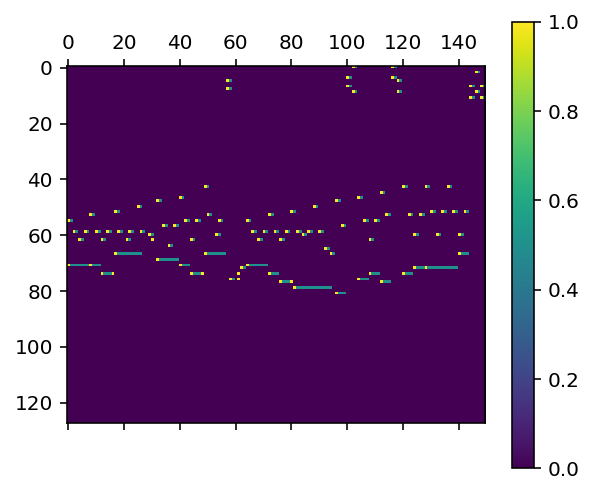

In [ ]:
#"Spectogram" of the differfent midi files
plt.matshow(midis_array[85]);
plt.colorbar()
plt.show()

In [ ]:
# Midis array shape --> (# of file, # of frx.eq, # of time in a single file)
# Firtly, I will convert to (# of file, # of time in a single file, # of freq,)

midis_array = np.transpose(midis_array_raw, (0, 2, 1)) 
midis_array = np.asarray(midis_array)
midis_array.shape

(161, 150, 128)

In [ ]:
# Secondly, convert to (# of freq, # of file * # of time in a single file)

midis_array = np.reshape(midis_array,(-1,128))
midis_array.shape

(24150, 128)

In [ ]:
max_len = 20 # how many column will take account to predict next column.
step = 1 # step size.

previous_full = []
predicted_full = []

for i in range (0, midis_array.shape[0]-max_len, step):
    prev = midis_array[i:i+max_len,...] # take max_len column.
    pred = midis_array[i+max_len,...] # take (max_len)th column.
    previous_full.append(prev)
    predicted_full.append(pred)

In [ ]:
previous_full = np.asarray(previous_full).astype('float64')
predicted_full = np.asarray (predicted_full).astype('float64')

In [ ]:
num_of_sample, max_len, freq = previous_full.shape

print (previous_full.shape)
print (predicted_full.shape)

(24130, 20, 128)
(24130, 128)


In [ ]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    num_of_top = 15
    num_of_first = np.random.randint(1,3)

    
    preds [0:48] = 0 # eliminate notes with low octaves
    preds [100:] = 0 # eliminate notes with very high octaves
    
    ind = np.argpartition(preds, -1*num_of_top)[-1*num_of_top:]
    top_indices_sorted = ind[np.argsort(preds[ind])]
    
    
    array = np.random.uniform(0.0, 0.0, (128)) 
    array[top_indices_sorted[0:num_of_first]] = 1.0
    array[top_indices_sorted[num_of_first:num_of_first+3]] = 0.5

    return array

In [ ]:
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import Dense
from keras.layers import LeakyReLU
import random
import sys

midi_shape = (max_len, 128)

input_midi = keras.Input(midi_shape)


model = Sequential()
model.add(LSTM(
        1024,
        input_shape=(midi_shape),
        return_sequences=True
    ))
model.add(Dropout(0.3))
model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(128))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
model.fit(previous_full, predicted_full, batch_size=30, epochs=100, validation_split=0.2) 

epoch_total = 120
batch_size = 20
for epoch in range(1, epoch_total): # Train model with epoch_total 
    print('Epoch:', epoch)
    model.fit(previous_full, predicted_full, batch_size=batch_size, epochs=1,
              validation_split = 0.2) # Fit model for 1 iteration.
    
    start_index = random.randint(0, len(midis_array)- max_len - 1)
    
    generated_midi = midis_array[start_index: start_index + max_len]
        
    if ((epoch%10) == 0):
      model.save_weights('my_model_weights.h5')

      for temperature in [1.2]:
          print('------ temperature:', temperature)

          for i in range(480):
              samples = generated_midi[i:]
              expanded_samples = np.expand_dims(samples, axis=0)
              preds = model.predict(expanded_samples, verbose=0)[0]
              preds = np.asarray(preds).astype('float64')

              next_array = sample(preds, temperature)
              
              midi_list = []
              midi_list.append(generated_midi)
              midi_list.append(next_array)
              generated_midi = np.vstack(midi_list)
              

          generated_midi_final = np.transpose(generated_midi,(1,0))
          output_notes = matrix_to_midi(generated_midi_final, random=1)
          midi_stream = stream.Stream(output_notes)
          midi_file_name = ('lstm_out_{}_{}.mid'.format(epoch, temperature))
          midi_stream.write('midi', fp=midi_file_name)
          parsed = converter.parse(midi_file_name)
          for part in parsed.parts:
              part.insert(0, instrument.Piano())
          parsed.write('midi', fp=midi_file_name)

Epoch: 1
966/966 [==============================] - 25s 26ms/step - loss: 10.5464 - val_loss: 9.5920
Epoch: 2
966/966 [==============================] - 24s 25ms/step - loss: 8.9863 - val_loss: 9.5920
Epoch: 3
966/966 [==============================] - 24s 25ms/step - loss: 9.0046 - val_loss: 9.5920
Epoch: 4
966/966 [==============================] - 24s 25ms/step - loss: 9.0309 - val_loss: 9.5920
Epoch: 5
966/966 [==============================] - 24s 25ms/step - loss: 8.9950 - val_loss: 9.5920
Epoch: 6
966/966 [==============================] - 24s 25ms/step - loss: 9.0739 - val_loss: 9.5920
Epoch: 7
966/966 [==============================] - 24s 25ms/step - loss: 8.9850 - val_loss: 9.5920
Epoch: 8
966/966 [==============================] - 24s 25ms/step - loss: 8.9675 - val_loss: 9.5920
Epoch: 9
966/966 [==============================] - 24s 25ms/step - loss: 9.0059 - val_loss: 9.5920
Epoch: 10
966/966 [==============================] - 24s 25ms/step - loss: 9.0255 - val_loss: 9.592

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


How many rows for non-start note at beginning: 5
How many rows for non-start note at end: 0
128 495
Epoch: 11
966/966 [==============================] - 24s 25ms/step - loss: 9.0222 - val_loss: 9.5920
Epoch: 12
966/966 [==============================] - 24s 25ms/step - loss: 9.0180 - val_loss: 9.5920
Epoch: 13
966/966 [==============================] - 24s 25ms/step - loss: 9.0213 - val_loss: 9.5920
Epoch: 14
966/966 [==============================] - 24s 25ms/step - loss: 8.9900 - val_loss: 9.5920
Epoch: 15
966/966 [==============================] - 24s 25ms/step - loss: 8.9984 - val_loss: 9.5920
Epoch: 16
966/966 [==============================] - 24s 25ms/step - loss: 9.0330 - val_loss: 9.5920
Epoch: 17
966/966 [==============================] - 24s 25ms/step - loss: 9.0593 - val_loss: 9.5920
Epoch: 18
966/966 [==============================] - 24s 25ms/step - loss: 9.0013 - val_loss: 9.5920
Epoch: 19
966/966 [==============================] - 24s 25ms/step - loss: 9.0247 - val_loss

In [ ]:
model.summary()

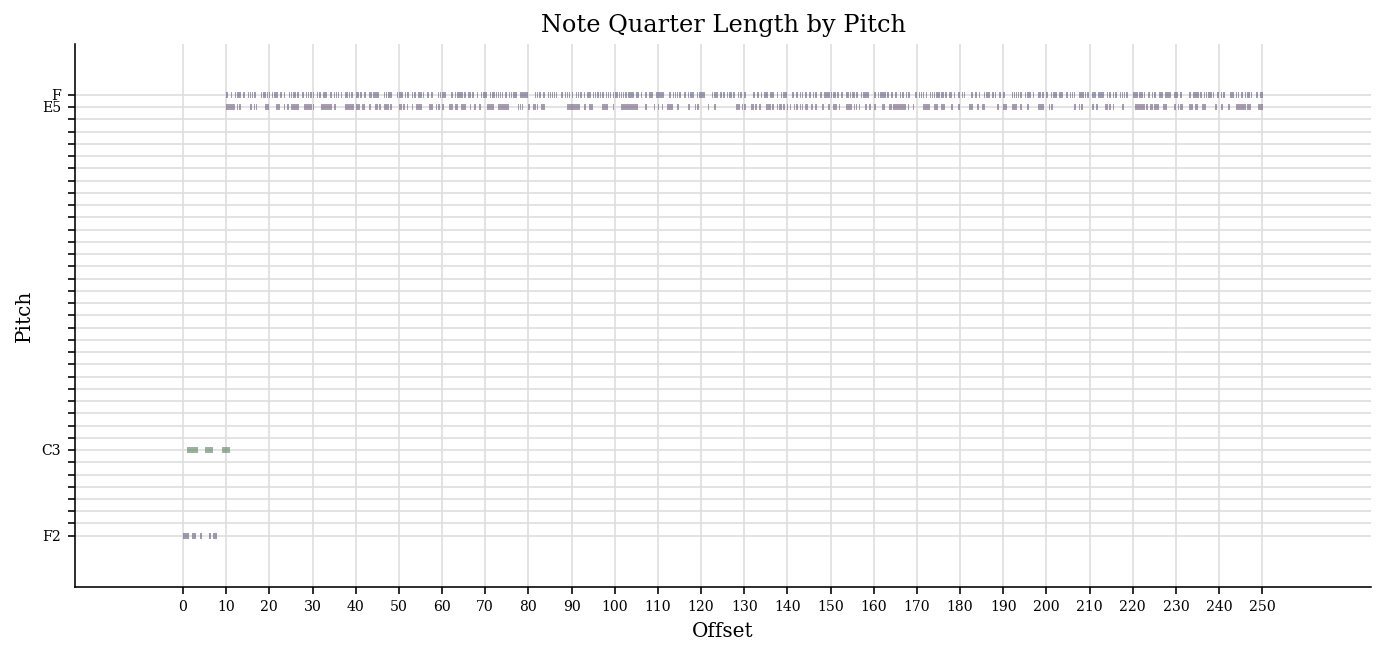

In [ ]:
from music21 import *
s = converter.parse('/content/drive/My Drive/Colab Notebooks/CDS/simplelstm.mid')
s.plot('pianoroll', figureSize=(12, 5))